In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import os
import datetime
import json
from pprint import pprint
from IPython.core import display as ICD  # to print multiple nice pandas tables
from collections import defaultdict
import logging
import numpy as np
import io
import gensim
from tqdm import tqdm_notebook, tnrange
import tqdm
import seaborn as sns
sns.set()

In [70]:
import datasets
import classify

In [23]:
from sklearn.linear_model import LogisticRegression
from gensim.models import TfidfModel
class SimpleModel(object):
    def __init__(self, cls = None, use_tfidf=False, w=None):
        self.cls = cls
        if self.cls is None:
            self.cls = LogisticRegression()
        self.use_tfidf = use_tfidf
        self.w=w
        

    def fit(self, X, Y):
        self.dictionary = gensim.corpora.Dictionary(X)
        self.num_terms = len(self.dictionary.dfs)
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            self.tfidf_model = TfidfModel(bow)
            bow = self.tfidf_model[bow]
        if self.w is None:
            self.w = np.ones(self.num_terms)
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            bow = gensim.matutils.Sparse2Corpus(bow.multiply(self.w.reshape(-1,1)))
        self.lsi = gensim.models.LsiModel(bow, id2word=self.dictionary)
        self.corpus = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        self.cls.fit(self.corpus, Y)
    
    def dw(self, X, Y):
        _ = self.predict(X)
        self.d_embedding = self.cls.dx(self.embedding, Y)
        u = self.lsi.projection.u
        res = self.d_embedding.dot(u.T)
        dw = model.bow.multiply(res.T).sum(axis=1).T.A1
        return dw
        
    
    def predict(self, X):
        bow = list(map(self.dictionary.doc2bow, X))
        if self.use_tfidf:
            bow = self.tfidf_model[bow]
        if True:
            bow = gensim.matutils.corpus2csc(bow, num_terms=self.num_terms)
            self.bow = bow
            bow = bow.multiply(self.w.reshape(-1,1))
            bow = gensim.matutils.Sparse2Corpus(bow)

        self.embedding = gensim.matutils.corpus2dense(self.lsi[bow], self.lsi.num_topics).T
        Yhat = self.cls.predict(self.embedding)
        return Yhat
    
    def score(self, X, Y):
        Yhat = self.predict(X)
        return 1-((Yhat-Y)**2).mean()
    
    def update(self, X, Y):
        pass

In [24]:
def noice_like(like, spread=0.01):
    rnd = np.random.random(size=like.shape)
    rnd *= spread
    rnd -= spread/2
    return rnd

# Check how balanced are the datasets

In [25]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]

In [26]:
for dataset in all_datasets:
    print(dataset.name(), dataset.baseline())

CRDataset 0.6376158940397351
MRDataset 0.5
SUBJDataset 0.5
MPQADataset 0.6877239298510277


In [27]:
results = {}

# Testing lsa + sklearn logistic regression 

In [48]:
def test_simple_model(model, dataset, iters=1, tag=None):
    precisions = []
    for it in tnrange(iters):
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    print(dataset.name())
    if tag is not None:
        results[('simple', tag, dataset.name())] = (train, test)
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

In [49]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model(model, dataset, 5, 'default')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))

Exception in thread Thread-18:
Traceback (most recent call last):
  File "/usr/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/vlejd/.virtualenvs/diplomka/lib/python3.5/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration




CRDataset
Train precision 0.7839269944068296 0.7848690020606417 0.7859876361495437
Test precision 0.7513227513227514 0.7576719576719577 0.7671957671957672


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.687441375716519 0.6895674830640959 0.691089108910891
Test precision 0.6588566073102156 0.6682286785379569 0.6766635426429242


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8855555555555555 0.8865555555555555 0.887888888888889
Test precision 0.868 0.8744 0.881


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.7591409114719748 0.7612781561026716 0.7623886851754845
Test precision 0.7342130065975494 0.7406220546654099 0.7474081055607917


# Testing lsa + custom logistic regression 

In [51]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.CustomClassifier())
    test_simple_model(model, dataset, 5, 'custom_regression')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.6376214306741242 0.6376214306741242 0.6376214306741242
Test precision 0.6375661375661376 0.6375661375661376 0.6375661375661376


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.500156331422616 0.6201980198019802 0.706618030224075
Test precision 0.4995313964386129 0.5964386129334583 0.6644798500468603


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.8795555555555555 0.8876 0.8937777777777778
Test precision 0.844 0.8573999999999999 0.865


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.6876898899947617 0.6876898899947617 0.6876898899947617
Test precision 0.6880301602262017 0.6880301602262017 0.6880301602262017


We see real decrease against sklearn classsifier in some tasks. In CR and MPQAD we hit the baseline, which is bad.

In [50]:
results

{('simple',
  'default',
  'CRDataset'): ((0.7851045039740948,
   0.7845157491904622,
   0.7839269944068296,
   0.7859876361495437,
   0.7848101265822784), (0.7671957671957672,
   0.7566137566137566,
   0.753968253968254,
   0.7513227513227514,
   0.7592592592592593)),
 ('simple',
  'default',
  'MPQADataset'): ((0.7591409114719748,
   0.7617600838135149,
   0.7623886851754845,
   0.7620743844944997,
   0.7610267155578837), (0.7436380772855796,
   0.7408105560791706,
   0.7474081055607917,
   0.7370405278039585,
   0.7342130065975494)),
 ('simple',
  'default',
  'MRDataset'): ((0.691089108910891,
   0.6896300156331423,
   0.687441375716519,
   0.6890046899426785,
   0.6906722251172486), (0.6635426429240863,
   0.6663542642924086,
   0.6588566073102156,
   0.6757263355201499,
   0.6766635426429242)),
 ('simple',
  'default',
  'SUBJDataset'): ((0.887888888888889,
   0.8865555555555555,
   0.8855555555555555,
   0.8868888888888888,
   0.885888888888889), (0.881, 0.875, 0.868, 0.876, 0.8

# Add tfidf

In [52]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model(model, dataset, 5, 'tfidf')

HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


CRDataset
Train precision 0.7895201648513395 0.7916396820724168 0.7959964674712983
Test precision 0.7592592592592593 0.76984126984127 0.7751322751322751


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MRDataset
Train precision 0.7153725898905681 0.7187910369984367 0.7222511724856696
Test precision 0.7047797563261481 0.7145267104029991 0.7347703842549204


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


SUBJDataset
Train precision 0.894 0.8964444444444444 0.8983333333333333
Test precision 0.884 0.89 0.894


HBox(children=(IntProgress(value=0, max=5), HTML(value='')))


MPQADataset
Train precision 0.7823991618648507 0.7852069146149816 0.7878470403352541
Test precision 0.7530631479736098 0.75626767200754 0.760603204524034


# Try improwing $w$ with gradient

In [98]:
def gradient_w(model, dataset, alpha=0.01, epochs=150):
    train_scores = []
    test_scores = []
    model.fit(dataset.train_samples(), dataset.train_labels())
    t = tnrange(epochs)
    for e in t:
        w = np.copy(model.w)
        w -= alpha * model.dw(dataset.train_samples(), dataset.train_labels())
        model.w = np.copy(w)
        model.fit(dataset.train_samples(), dataset.train_labels())
        train_score = model.score(dataset.train_samples(), dataset.train_labels())
        test_score = model.score(dataset.test_samples(), dataset.test_labels())
        train_scores.append(train_score)
        test_scores.append(test_score)
        t.set_postfix(train_score=train_score, test_score=test_score)
    plt.plot(train_scores,)
    plt.plot(test_scores)
    plt.legend(['train', 'test'])
    return train_scores, test_scores

In [99]:
def test_simple_model_with_gradient(model, dataset, iters=1, gradient_iters=150, alpha=0.01, tag=None):
    precisions = []
    for it in tnrange(iters):
        _ = gradient_w(model, dataset, alpha, gradient_iters)
        train_p = model.score(dataset.train_samples(), dataset.train_labels())
        test_p = model.score(dataset.test_samples(), dataset.test_labels())
        precisions.append((train_p, test_p))
    train, test = list(zip(*precisions))
    if tag is not None:
        results[('gradientw', tag, dataset.name())] = (train, test)
    plt.show()
    print(dataset.name())
    print("Train precision", np.min(train), np.mean(train), np.max(train))
    print("Test precision", np.min(test), np.mean(test), np.max(test))

# Precision of model when we do not update $w$

it is basically 150 fits of LSA + logistic regression

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

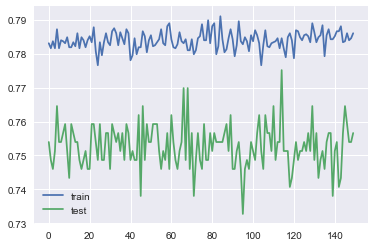

CRDataset
Train precision 0.7859876361495437 0.7859876361495437 0.7859876361495437
Test precision 0.7566137566137566 0.7566137566137566 0.7566137566137566


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

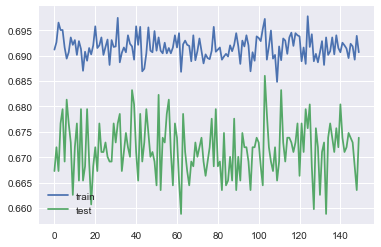

MRDataset
Train precision 0.6906722251172486 0.6906722251172486 0.6906722251172486
Test precision 0.6738519212746017 0.6738519212746017 0.6738519212746017


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

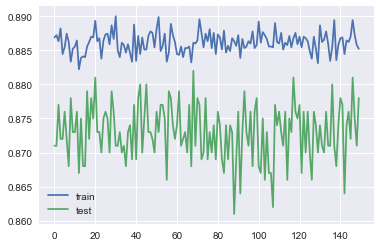

SUBJDataset
Train precision 0.8852222222222222 0.8852222222222222 0.8852222222222222
Test precision 0.878 0.878 0.878


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

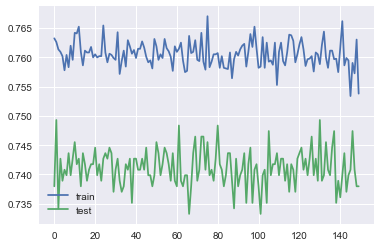

MPQADataset
Train precision 0.7537977998952331 0.7537977998952331 0.7537977998952331
Test precision 0.7379830348727616 0.7379830348727616 0.7379830348727616


In [106]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, 1, alpha=0, tag='default')

# Precision, when we do update w

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

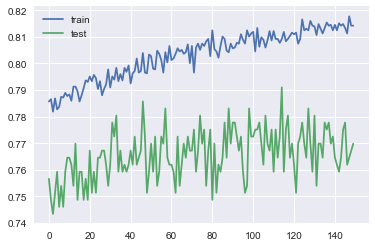

CRDataset
Train precision 0.8142478657639094 0.8142478657639094 0.8142478657639094
Test precision 0.7698412698412699 0.7698412698412699 0.7698412698412699


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

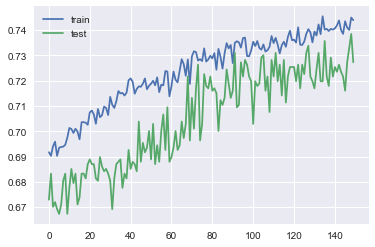

MRDataset
Train precision 0.7439291297550807 0.7439291297550807 0.7439291297550807
Test precision 0.7272727272727273 0.7272727272727273 0.7272727272727273


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

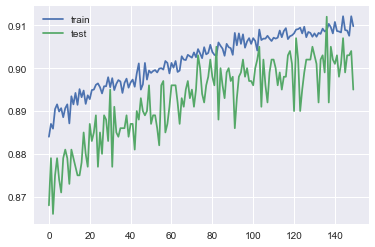

SUBJDataset
Train precision 0.9097777777777778 0.9097777777777778 0.9097777777777778
Test precision 0.895 0.895 0.895


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

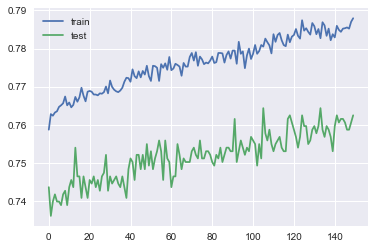

MPQADataset
Train precision 0.7879518072289157 0.7879518072289157 0.7879518072289157
Test precision 0.76248821866164 0.76248821866164 0.76248821866164


In [107]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, 1, alpha=0.01, tag='default')

update with smaller $\alpha$

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

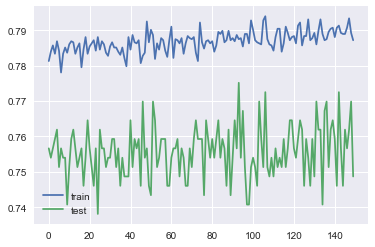

CRDataset
Train precision 0.787165145716809 0.787165145716809 0.787165145716809
Test precision 0.7486772486772486 0.7486772486772486 0.7486772486772486


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

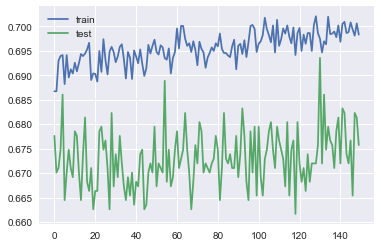

MRDataset
Train precision 0.6982803543512246 0.6982803543512246 0.6982803543512246
Test precision 0.6757263355201499 0.6757263355201499 0.6757263355201499


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

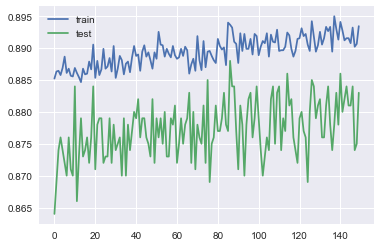

SUBJDataset
Train precision 0.8934444444444445 0.8934444444444445 0.8934444444444445
Test precision 0.883 0.883 0.883


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

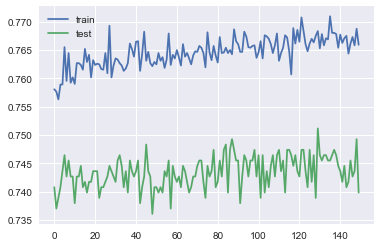

MPQADataset
Train precision 0.765950759559979 0.765950759559979 0.765950759559979
Test precision 0.7398680490103675 0.7398680490103675 0.7398680490103675


In [108]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier())
    test_simple_model_with_gradient(model, dataset, 1, alpha=0.001, tag='default')

# Use tfidf, then $w$

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

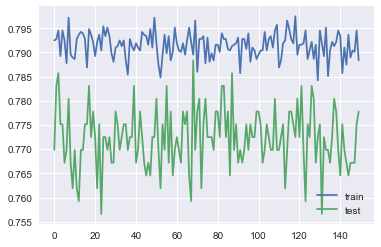

CRDataset
Train precision 0.7883426552840742 0.7883426552840742 0.7883426552840742
Test precision 0.7777777777777778 0.7777777777777778 0.7777777777777778


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

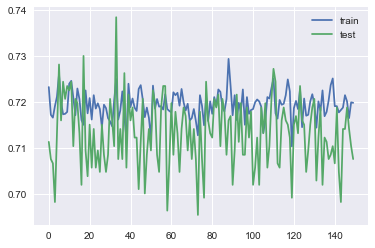

MRDataset
Train precision 0.719854090672225 0.719854090672225 0.719854090672225
Test precision 0.7075913776944704 0.7075913776944704 0.7075913776944704


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

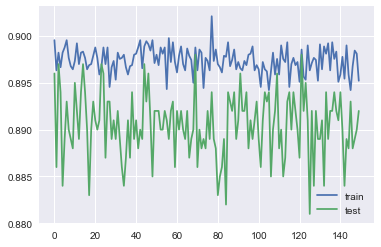

SUBJDataset
Train precision 0.8952222222222223 0.8952222222222223 0.8952222222222223
Test precision 0.892 0.892 0.892


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

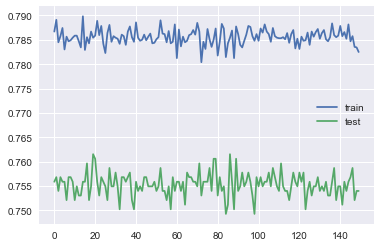

MPQADataset
Train precision 0.7825039287585123 0.7825039287585123 0.7825039287585123
Test precision 0.7540056550424128 0.7540056550424128 0.7540056550424128


In [109]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, 1, alpha=0, tag='tfidf')

# Use tfidf, then updating $w$

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

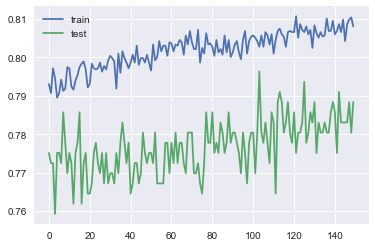

CRDataset
Train precision 0.8080659405357669 0.8080659405357669 0.8080659405357669
Test precision 0.7883597883597884 0.7883597883597884 0.7883597883597884


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

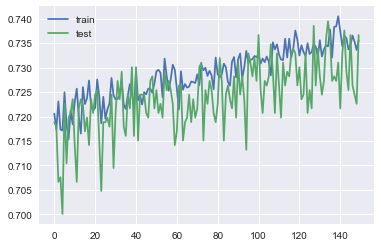

MRDataset
Train precision 0.7355914538822304 0.7355914538822304 0.7355914538822304
Test precision 0.7366447985004686 0.7366447985004686 0.7366447985004686


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

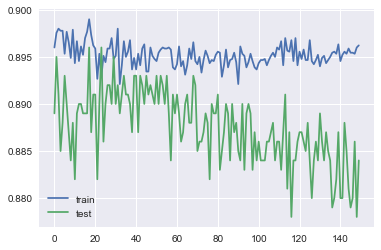

SUBJDataset
Train precision 0.8962222222222223 0.8962222222222223 0.8962222222222223
Test precision 0.884 0.884 0.884


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

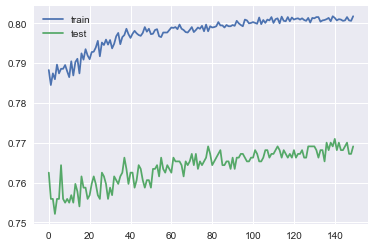

MPQADataset
Train precision 0.8017810371922472 0.8017810371922472 0.8017810371922472
Test precision 0.769085768143261 0.769085768143261 0.769085768143261


In [110]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, 1, alpha=0.01, tag='tfidf')

updating with smaller $\alpha$

HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

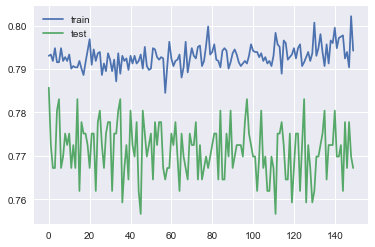

CRDataset
Train precision 0.7942302031204004 0.7942302031204004 0.7942302031204004
Test precision 0.7671957671957672 0.7671957671957672 0.7671957671957672


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

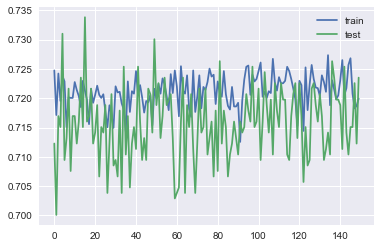

MRDataset
Train precision 0.7199583116206357 0.7199583116206357 0.7199583116206357
Test precision 0.7235238987816308 0.7235238987816308 0.7235238987816308


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

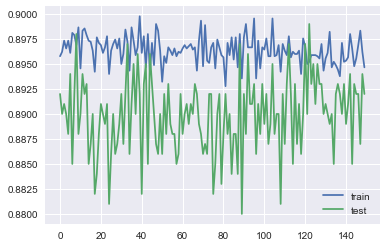

SUBJDataset
Train precision 0.8946666666666667 0.8946666666666667 0.8946666666666667
Test precision 0.892 0.892 0.892


HBox(children=(IntProgress(value=0, max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=150), HTML(value='')))

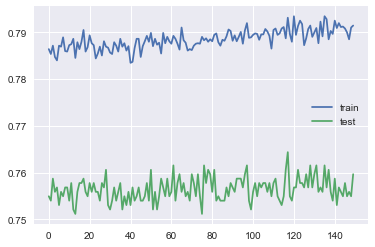

MPQADataset
Train precision 0.7914091147197486 0.7914091147197486 0.7914091147197486
Test precision 0.7596606974552309 0.7596606974552309 0.7596606974552309


In [111]:
all_datasets = [datasets.CRDataset(), datasets.MRDataset(), datasets.SUBJDataset(), datasets.MPQADataset()]
for dataset in all_datasets:
    model = SimpleModel(classify.SkClassifier(), use_tfidf=True)
    test_simple_model_with_gradient(model, dataset, 1, alpha=0.001, tag='tfidf')